In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import ast, seaborn as sns
from adjustText import adjust_text
from datetime import datetime as dt
from matplotlib.ticker import FuncFormatter
from datasets import load_dataset


#setup
dataset = load_dataset('lukebarousse/data_jobs')
csv = dataset['train'].to_pandas()
csv["job_posted_date"] = pd.to_datetime(csv["job_posted_date"])
csv['job_skills'] = csv['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
csv = csv[csv['job_country'] == 'United States'] #US jobs only


In [2]:
csv_grouped = csv.explode('job_skills').copy()

In [3]:
top_3_jobs = csv['job_title_short'].value_counts().head(3).index.tolist()
csv_grouped = csv_grouped[csv_grouped['job_title_short'].isin(top_3_jobs)].copy()

In [4]:
csv_grouped = csv_grouped.groupby(['job_title_short', 'job_skills']).agg(skill_count=('job_skills', 'count'))

In [5]:
csv_grouped.reset_index(inplace=True)

In [6]:
csv_grouped.index.name = 'index'

In [7]:
csv_grouped.sort_values(by='skill_count', inplace=True, ascending=False)

In [8]:
csv_job_title_count = csv['job_title_short'].value_counts().reset_index(name='jobs_total').copy()

In [9]:
csv_skills_perc = pd.merge(left=csv_grouped, right=csv_job_title_count, how='left', on='job_title_short')

In [10]:
csv_skills_perc['skills_percentage'] = 100 * csv_skills_perc['skill_count'] / csv_skills_perc['jobs_total']

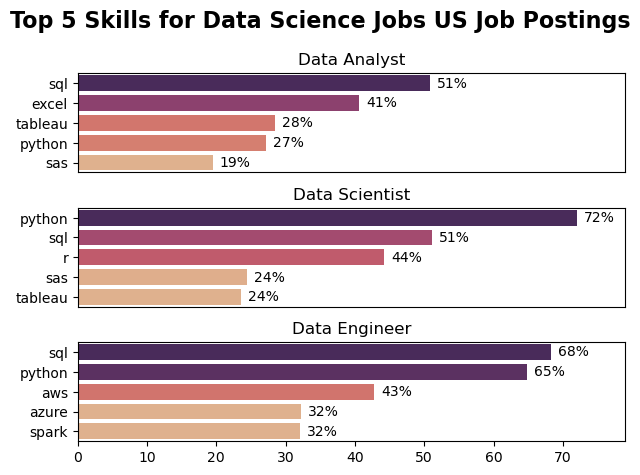

In [13]:
fig, ax = plt.subplots(len(top_3_jobs), 1)

for i, job_title in enumerate(top_3_jobs):
    csv_plot = csv_skills_perc[csv_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(
        data=csv_plot,
        x='skills_percentage',
        y='job_skills',
        ax=ax[i],
        hue='skills_percentage',
        palette='flare',
        legend=False,
    )
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_xlim(0, 79)

    if i != len(top_3_jobs) - 1: #len of top_3_jobs is 3 when i starts from 0
        ax[i].set_xticks([])

    for j, perc in enumerate(csv_plot['skills_percentage']):
        ax[i].text(perc+1, j, f'{perc:.0f}%',va='center')

fig.suptitle('Top 5 Skills for Data Science Jobs US Job Postings', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()